In [31]:
import numpy as np
import matplotlib.pyplot as plt

import wf_psf

In [32]:
# Paths

# SED folder path
SED_path = './../../../wf-psf/data/SEDs/save_SEDs/'

# Reference dataset PATH
reference_data = '../interp_SED_data/reference_dataset/'
ref_train = 'train_Euclid_res_2000_TrainStars_id_001.npy'
ref_test  = 'test_Euclid_res_id_001.npy'

# Datasets PATH
dataset_path = '/Users/ec270266/Desktop/Stage-CEA/output/interp_SEDs/'
dataset_train_file = 'train_Euclid_res_2000_TrainStars_id_009GT_350_bins.npy'
dataset_test_file = 'test_Euclid_res_id_009GT_350_bins.npy'


In [33]:
# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)

SED_name = ['O5V', 'B0V', 'B5-7V', 'A0V', 'A5V', 'F0V', 'F5V', 'G0V', 'G5V', 'K0V', 'K5V', 'M0V', 'M5V']

In [34]:
# Load datasets
train_dataset_ref = np.load(reference_data+ref_train, allow_pickle=True)[()]
test_dataset_ref = np.load(reference_data+ref_test, allow_pickle=True)[()]

train_dataset = np.load(dataset_path+dataset_train_file, allow_pickle=True)[()]
test_dataset = np.load(dataset_path+dataset_test_file, allow_pickle=True)[()]

print('Reference datasets keys:')
print(list(train_dataset_ref.keys()))
print(list(test_dataset_ref.keys()))

print('\nGT dataset keys:')
print(list(train_dataset.keys()))
print(list(test_dataset.keys()))

Reference datasets keys:
['stars', 'noisy_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters']
['stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters']

GT dataset keys:
['stars', 'noisy_stars', 'super_res_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters']
['stars', 'super_res_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters']


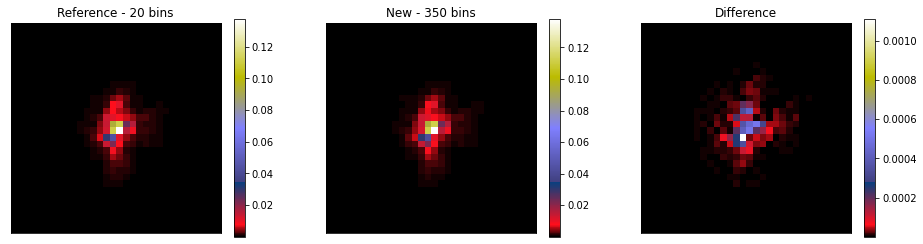

In [35]:
# Display some PSFs

display_star = 4

fig, ax = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(train_dataset_ref['stars'][display_star,:,:], cmap='gist_stern')
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Reference - 20 bins')
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(train_dataset['stars'][display_star,:,:], cmap='gist_stern')
plt.colorbar(im, ax=ax[1])
ax[1].set_title('New - 350 bins')
ax[1].set_xticks([])
ax[1].set_yticks([])

im = ax[2].imshow(np.abs(train_dataset['stars'][display_star,:,:]- train_dataset_ref['stars'][display_star,:,:]), cmap='gist_stern')
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
ax[2].set_xticks([])
ax[2].set_yticks([])


plt.show()

# Generate SEDs

In [36]:
# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 8
auto_init = True
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

pupil_diameter = 256

# Super resolved PSFs
super_out_Q = 1
super_out_res = 64

In [37]:
# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=super_out_Q, output_dim=super_out_res, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)

In [38]:
# Generate binned and interpolated SEDs for training and testing

SED_8_train_list = [gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(star_SED,8) for star_SED in train_dataset['SEDs']]
SED_16_train_list = [gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(star_SED, 1, 8) for star_SED in SED_8_train_list ]
SED_32_train_list = [gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(star_SED, 3, 8) for star_SED in SED_8_train_list ]

SED_8_test_list = [gen_poly_fieldPSF.sim_psf_toolkit.filter_SED(star_SED,8) for star_SED in test_dataset['SEDs']]
SED_16_test_list = [gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(star_SED, 1, 8) for star_SED in SED_8_test_list ]
SED_32_test_list = [gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(star_SED, 3, 8) for star_SED in SED_8_test_list ]

SED_8_train = np.stack(SED_8_train_list)
SED_16_train = np.stack(SED_16_train_list)
SED_32_train = np.stack(SED_32_train_list)

SED_8_test = np.stack(SED_8_test_list)
SED_16_test = np.stack(SED_16_test_list)
SED_32_test = np.stack(SED_32_test_list)


In [10]:
# Save the noisless datasets

# 8 bins
train_dataset['SEDs'] = SED_8_train 
test_dataset['SEDs'] = SED_8_test
np.save(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_8_bins_sigma_0.npy', train_dataset, allow_pickle=True)
np.save(dataset_path+'test_Euclid_res_id_009_8_bins.npy', test_dataset, allow_pickle=True)

# 16 bins
train_dataset['SEDs'] = SED_16_train 
test_dataset['SEDs'] = SED_16_test
np.save(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_16_bins_sigma_0.npy', train_dataset, allow_pickle=True)
np.save(dataset_path+'test_Euclid_res_id_009_16_bins.npy', test_dataset, allow_pickle=True)

# 32 bins
train_dataset['SEDs'] = SED_32_train 
test_dataset['SEDs'] = SED_32_test
np.save(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_32_bins_sigma_0.npy', train_dataset, allow_pickle=True)
np.save(dataset_path+'test_Euclid_res_id_009_32_bins.npy', test_dataset, allow_pickle=True)

In [40]:
# Add noise to the 8 bin SED
sigma_list = [0.005, 0.01, 0.02]

for sigma in sigma_list:
    # Load the 8 bin dataset add noise and save it
    train_dataset = np.load(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_8_bins_sigma_0.npy', allow_pickle=True)[()]
    train_dataset['SEDs'][:,:,1] += np.multiply(train_dataset['SEDs'][:,:,1], gen_poly_fieldPSF.sim_psf_toolkit.SED_gen_noise(train_dataset['SEDs'].shape[:2], sigma))
    np.save(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_8_bins_sigma_{}.npy'.format(sigma), train_dataset, allow_pickle=True)
    # Interpolate from the noisy 8 bin dataset
    SED_16_train = np.stack([gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(star_SED, 1, 8) for star_SED in train_dataset['SEDs']])
    SED_32_train = np.stack([gen_poly_fieldPSF.sim_psf_toolkit.interp_SED(star_SED, 3, 8) for star_SED in train_dataset['SEDs']])
    # Save interpolated SEDs data
    train_dataset['SEDs'] = SED_16_train 
    np.save(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_16_bins_sigma_{}.npy'.format(sigma), train_dataset, allow_pickle=True)
    train_dataset['SEDs'] = SED_32_train 
    np.save(dataset_path+'train_Euclid_res_2000_TrainStars_id_009_32_bins_sigma_{}.npy'.format(sigma), train_dataset, allow_pickle=True)

